In this notebook, we would analyzing NYT best selling authors over a period of 2008-2017. We are trying to understand the gender skews in the best selling authors. However gender is not directly present, so we use NYSIIS phonetic algorithm to dechipher gender based on name.

**Brief about phonetics:**

<p>Words like Grey and Gray. Colour and Color. are equivalent and many a times just a result of accents. While it is easy for us to realize their equivalence, basic programming commands will fail to equate such two strings. </p>

<p>To tackle this issue, we check for equivalence in spellings using fuzzy name matching.</p>

Fuzzy is a package that provides a number of functions for performing fuzzy matching. we are using NYSIIS https://en.wikipedia.org/wiki/New_York_State_Identification_and_Intelligence_System

In [27]:
import fuzzy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline


In [2]:
# a sample check
print(fuzzy.nysiis('hare'))

print(fuzzy.nysiis('hair'))

HAR
HAR


**NYT data**
<p>The New York Times puts out a list of best-selling books from different genres, and which has been published since the 1930’s.  Here wr have Children’s Picture Books data, and we analyze the gender distribution of authors.</p>

In [3]:
author_df = pd.read_csv('datasets/nytkids_yearly.csv', delimiter=';')


# gathering the first name of the author
first_name = []
for name in author_df['Author']:
    first_name.append(name.split()[0])


author_df['first_name'] = pd.Series(first_name)
author_df.head()

,Year,Book Title,Author,Besteller this year,first_name
0,2017,DRAGONS LOVE TACOS,Adam Rubin,49,Adam
1,2017,THE WONDERFUL THINGS YOU WILL BE,Emily Winfield Martin,48,Emily
2,2017,THE DAY THE CRAYONS QUIT,Drew Daywalt,44,Drew
3,2017,"ROSIE REVERE, ENGINEER",Andrea Beaty,38,Andrea
4,2017,"ADA TWIST, SCIENTIST",Andrea Beaty,28,Andrea


<p>We will now create a new column or list that contains the phonetic equivalent of every first name that we just extracted. </p>

In [4]:
# the nysiis (fuzzy) equivalent of author's first names
nysiis_name = []
for n in author_df['first_name']:
        nysiis_name.append(fuzzy.nysiis(n))


author_df['nysiis_name'] = pd.Series(nysiis_name)
print(author_df['first_name'].nunique() - author_df['nysiis_name'].nunique())

25


In [5]:
author_df.head()

,Year,Book Title,Author,Besteller this year,first_name,nysiis_name
0,2017,DRAGONS LOVE TACOS,Adam Rubin,49,Adam,ADAN
1,2017,THE WONDERFUL THINGS YOU WILL BE,Emily Winfield Martin,48,Emily,ENALY
2,2017,THE DAY THE CRAYONS QUIT,Drew Daywalt,44,Drew,DR
3,2017,"ROSIE REVERE, ENGINEER",Andrea Beaty,38,Andrea,ANDR
4,2017,"ADA TWIST, SCIENTIST",Andrea Beaty,28,Andrea,ANDR


**nysiis names to gender dataset**
<p>We'll use <code>babynames_nysiis.csv</code>, a dataset that is derived from <a href="https://www.ssa.gov/oact/babynames/limits.html">the Social Security Administration’s baby name data</a>, to identify author genders. The dataset contains unique NYSIIS versions of baby names, and also includes the percentage of times the name appeared as a female name (<code>perc_female</code>) and the percentage of times it appeared as a male name (<code>perc_male</code>). </p>
<p>We can use the percentage columns to assign a gender to each name.</p>

In [6]:
babies_df = pd.read_csv('datasets/babynames_nysiis.csv', delimiter=';')


In [7]:
gender = []
for l in babies_df.iterrows():
    gender.append('M' if l[1]['perc_male']>l[1]['perc_female'] else 'F' if l[1]['perc_female']>l[1]['perc_male'] else 'N')

babies_df['gender'] = pd.Series(gender)
babies_df.head()

,babynysiis,perc_female,perc_male,gender
0,NaN,62.50,37.50,F
1,RAX,63.64,36.36,F
2,ESAR,44.44,55.56,M
3,DJANG,0.00,100.00,M
4,PARCAL,25.00,75.00,M



<p>Now we can identifythe likely genders of different names </p>

In [9]:
def locate_in_list(a_list, element):
    loc_of_name = a_list.index(element) if element in a_list else -1
    return(loc_of_name)


author_gender = []
for a in author_df['nysiis_name']:    
    loc = locate_in_list(list(babies_df['babynysiis']), a)
    if loc>0:
        author_gender.append(babies_df.iloc[loc,:]['gender'])
    else:
        author_gender.append('Unknown')    

In [10]:
author_df['author_gender'] = pd.Series(author_gender)
author_df['author_gender'].value_counts()

F          395
M          191
Unknown      9
N            8
Name: author_gender, dtype: int64

In [11]:
years = author_df.Year.unique()


males_by_yr = []
females_by_yr = []
unknown_by_yr = []

for y in years:
    females_by_yr.append(len( author_df[ (author_df['author_gender']=='F') &  (author_df['Year'] == y)]))
    males_by_yr.append(len( author_df[ (author_df['author_gender']=='M') &  (author_df['Year'] == y)]))    
    unknown_by_yr.append(len( author_df[ (author_df['author_gender']=='N') &  (author_df['Year'] == y)]))    
    

# Printing out yearly values to examine changes over time
print(years)
print(males_by_yr)
print(females_by_yr)
print(unknown_by_yr)


[2017 2016 2015 2014 2013 2012 2011 2010 2009 2008]
[20, 25, 18, 21, 11, 21, 21, 27, 19, 8]
[43, 32, 30, 34, 51, 46, 51, 48, 45, 15]
[0, 1, 0, 1, 1, 2, 1, 1, 0, 1]


Text(0, 0.5, 'count')

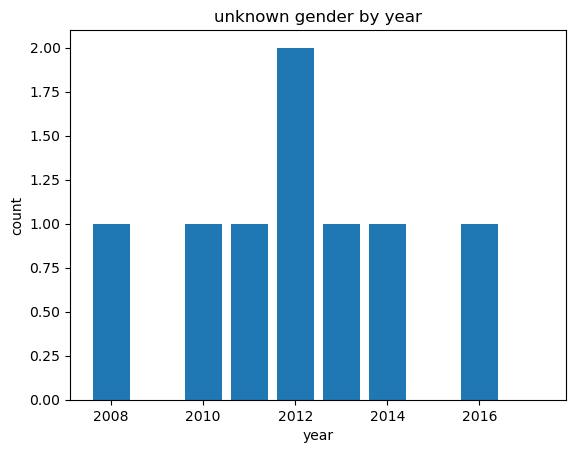

In [13]:
# Plotting the bar chart
plt.bar(years,unknown_by_yr)
plt.title('unknown gender by year')
plt.xlabel('year')
plt.ylabel('count')

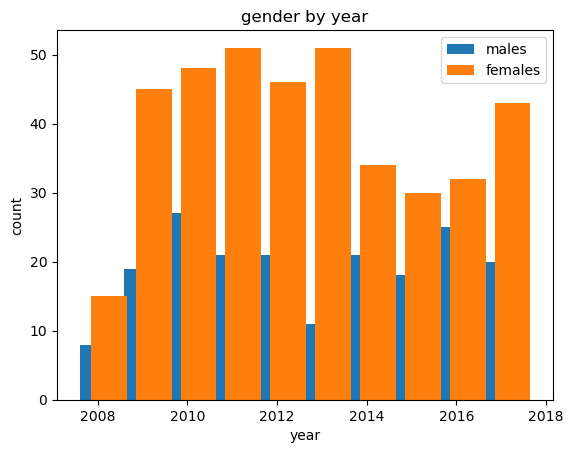

In [14]:

years_shifted = [i+0.25 for i in years] # for ease of plotting two bars on the same x-axis
plt.bar(years,males_by_yr,  label = 'males')
plt.bar(years_shifted,females_by_yr, label = 'females')
plt.title('gender by year')
plt.xlabel('year')
plt.ylabel('count')
plt.legend()

**Using sentence embeddings for further analysis**

In [17]:
# use a sentence embedding model to get a vector representation
emb_model = SentenceTransformer('all-MiniLM-L6-v2') 



In [24]:
name_emb = emb_model.encode(list(author_df['first_name']))

In [25]:
# add the embedding to the dataframe
author_df['name_emb'] = pd.Series(name_emb.tolist())

In [26]:
author_df.head()

,Year,Book Title,Author,Besteller this year,first_name,nysiis_name,author_gender,title_emb,name_emb
0,2017,DRAGONS LOVE TACOS,Adam Rubin,49,Adam,ADAN,M,"[-0.02643132582306862, 0.008773579262197018, 0...","[-0.03669535741209984, 0.04638153314590454, 0...."
1,2017,THE WONDERFUL THINGS YOU WILL BE,Emily Winfield Martin,48,Emily,ENALY,F,"[-0.06579064577817917, 0.0638495683670044, 0.1...","[-0.027905119583010674, -0.035634201020002365,..."
2,2017,THE DAY THE CRAYONS QUIT,Drew Daywalt,44,Drew,DR,M,"[-0.0002655674470588565, 0.008496149443089962,...","[-0.07107008993625641, 0.028695998713374138, -..."
3,2017,"ROSIE REVERE, ENGINEER",Andrea Beaty,38,Andrea,ANDR,M,"[-0.10482732951641083, -0.012104840949177742, ...","[-0.0691065639257431, 0.11003044992685318, 0.0..."
4,2017,"ADA TWIST, SCIENTIST",Andrea Beaty,28,Andrea,ANDR,M,"[-0.10044239461421967, -0.0004628612077794969,...","[-0.0691065639257431, 0.11003044992685318, 0.0..."


In [33]:
# get some nysiis_names which occur more than once
author_df['nysiis_name'].value_counts()

JAN       72
M         43
ERAC      26
DAVAD     16
AN        15
          ..
TAN        1
AL         1
LABAN      1
MY         1
WALTAR     1
Name: nysiis_name, Length: 145, dtype: int64

In [40]:
author_df[author_df['nysiis_name']=='JAN'][['first_name','nysiis_name']].drop_duplicates()

,first_name,nysiis_name
20,James,JAN
31,Jean,JAN
61,Jan,JAN
87,Jon,JAN
103,John,JAN
196,Jane,JAN
218,Joan,JAN
555,Jonah,JAN


In [41]:
# check the cosine similarity of embeddings where nysiss name is 'JAN' and first_name is 'JAMES' vs 'Jonah'
cosine_similarity( np.array(author_df[ (author_df['nysiis_name']=='JAN') &  (author_df['first_name']=='James')  ]['name_emb'].values[0]).reshape(1, -1), \
    np.array(author_df[(author_df['nysiis_name']=='JAN') &  (author_df['first_name']=='Jonah')]['name_emb'].values[0]).reshape(1, -1) )


array([[0.31129039]])

Noticably, we can see, had we used only cosine similarity of embeddings instead of phonetic similarity through NYSIIS, we would have lost the similarity between names likes James and Jonah.

> lets try clustering based on name embeddings:

In [54]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [55]:
# perform k-means clustering on the name embeddings
kmeans = KMeans(n_clusters=2, random_state=0, n_init='auto').fit(name_emb)

# evaluate the clustering
print(kmeans.inertia_) # lower is better

392.1187438964844


In [56]:
#the silhouette score


silhouette_score(name_emb, kmeans.labels_)

0.052954305

In [57]:
kmeans = KMeans(n_clusters=10, random_state=0, n_init='auto').fit(name_emb)

# evaluate the clustering
print(kmeans.inertia_)

289.41851806640625


In [58]:
silhouette_score(name_emb, kmeans.labels_)

0.1920995

In [67]:

silhouette_scores = []
for i in range(2,120,3):
    kmeans = KMeans(n_clusters=i, random_state=0, n_init='auto').fit(name_emb)
    silhouette_scores.append(silhouette_score(name_emb, kmeans.labels_))

Text(0.5, 1.0, 'silhouette score by number of clusters')

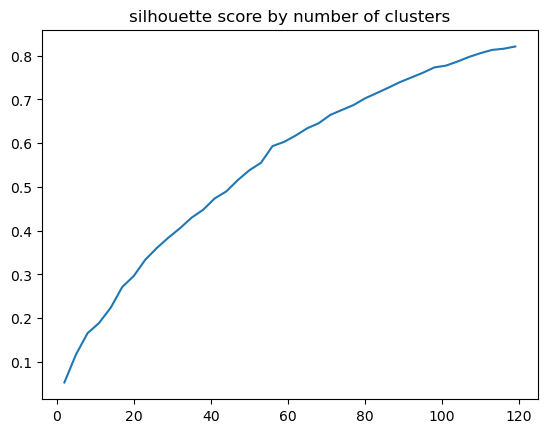

In [68]:
plt.plot(range(2,120,3), silhouette_scores)
plt.title('silhouette score by number of clusters')

> n_clusters of 120 is a good fit for number of clusters